In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
import os

#Train_data
directory_path = './datasets/train_data'
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
combined_df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path,usecols=["ax1","ay1","az1","ax2","ay2","az2","ax3","ay3","az3","ax4","ay4","az4"])
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# df = pd.read_csv("./record_11.csv", usecols=["ax1","ay1","az1","ax2","ay2","az2","ax3","ay3","az3","ax4","ay4","az4"])
N = 60
print(combined_df.shape)
num_slices = combined_df.shape[0]//N
temp = combined_df.values[:num_slices*N,:]
train_data = temp.reshape((num_slices,N,12))

#Train lablels
combined_df2 = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path,usecols=["label"])
    combined_df2 = pd.concat([combined_df2, df], ignore_index=True)

# df2 = pd.read_csv("./record_11.csv", usecols=["label"])
temp2 = combined_df2.values[:(combined_df2.shape[0]//N)*N].reshape((-1,N))
def fn(v):
    counts = np.bincount(v)
    return 0 if counts[0]>50 else 1
train_label = np.array([fn(v) for v in  temp2])
print(train_data.shape)
print(train_label.shape)
print(Counter(train_label[:]))




(1663783, 12)
(27729, 60, 12)
(27729,)
Counter({0: 27147, 1: 582})


[6724 6884 6820 6676 7064 6964 6844 6744 6936 6952 6876 6752 7164 6912
 6904 6796 6668 6968 6888 6940 7052 6956 7104 6932 6944 6756 6948 6776
 6856 7012 6748 6852 6980 6884 6908 6844 6768 7160 7008 6880 7040 6876
 7060 6844 6980 6976 6924 6884 6664 6824 6764 6908 6760 6692 6768 6708
 6872 6792 6852 6716]


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  warnings.warn('nperseg = {0:d} is greater than input length '


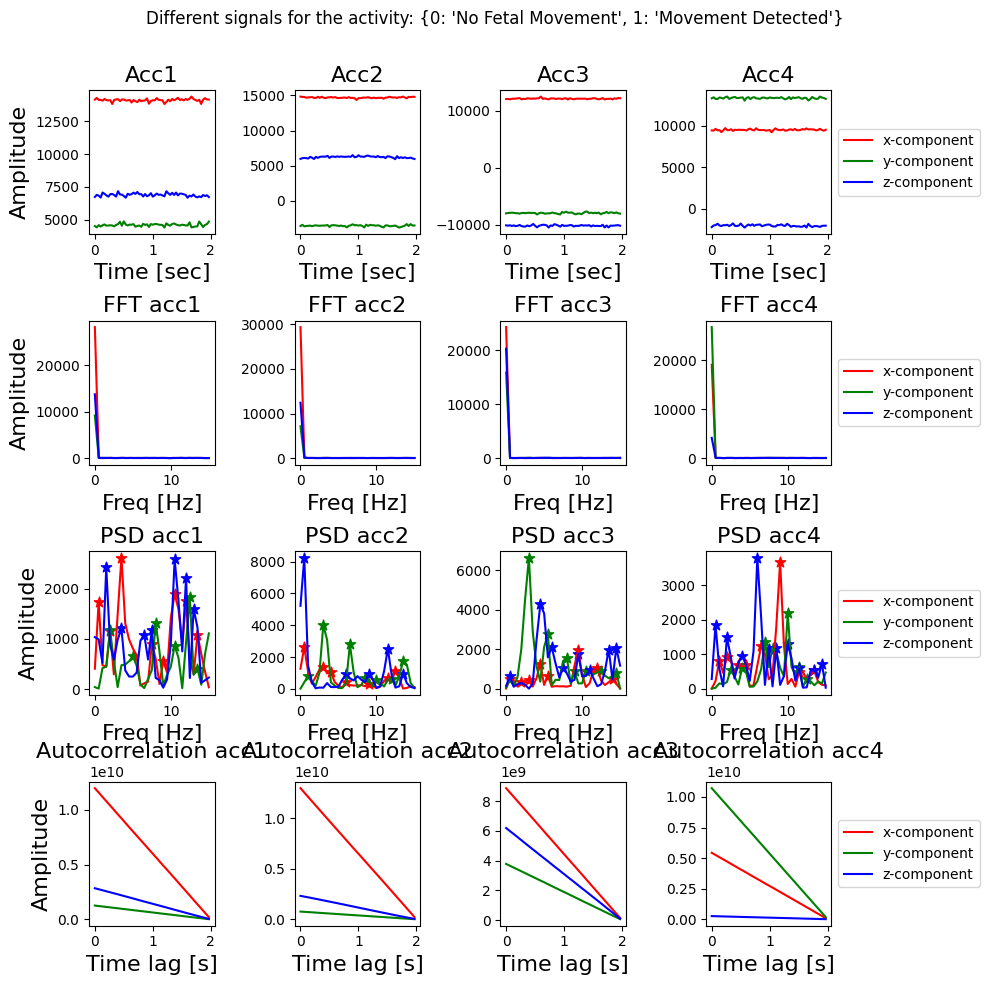

(27729, 360)


In [2]:

#Signal processing functions
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [T * kk for kk in range(0,len(y_values))]
    return x_values, y_values

from scipy.fftpack import fft
 
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

from scipy.signal import welch
 
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values


train_label_name = {
    0: 'No Fetal Movement',
    1: 'Movement Detected',
}

N = 60
f_s = 30
# t_n = 2
T = 1/f_s
denominator = 10
signal_no = 5000
signals = train_data[signal_no,:,:]
signal = signals[:,2]
label = train_label[signal_no]
label_name = train_label_name[label]
print(signal)
f_values, fft_values = get_fft_values(signal, T, N, f_s)

# plt.plot(f_values, fft_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]', fontsize=16)
# plt.ylabel('Amplitude', fontsize=16)
# plt.title("Frequency domain of the signal", fontsize=16)
# plt.show()

f_values, psd_values = get_psd_values(signal, T, N, f_s)
 
# plt.plot(f_values, psd_values, linestyle='-', color='blue')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('PSD [V**2 / Hz]')
# plt.show()

t_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)
 
# plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
# plt.xlabel('time delay [s]')
# plt.ylabel('Autocorrelation amplitude')
# plt.show()

from detect_peaks import detect_peaks



labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acc1', 'Acc2', 'Acc3', 'Acc4'],
            ['FFT acc1', 'FFT acc2', 'FFT acc3', 'FFT acc4'],
            ['PSD acc1', 'PSD acc2', 'PSD acc3', 'PSD acc4'],
            ['Autocorrelation acc1', 'Autocorrelation acc2', 'Autocorrelation acc3', 'Autocorrelation acc4'],
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
f.suptitle(suptitle.format(train_label_name), fontsize=12)
 
for row_no in range(0,4):
    for comp_no in range(0,12):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 3:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()




def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)
 
denominator = 10
X_train, Y_train = extract_features_labels(train_data, train_label, T, N, f_s, denominator)
print(X_train.shape)
# X_test, Y_test = extract_features_labels(test_data, test_labels, T, N, f_s, denominator)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
 
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
# print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
# Y_test_pred = clf.predict(X_test)
# print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 0.9999278733455949


In [4]:
#Test_data
directory_path = './datasets/test_data'
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
combined_df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path,usecols=["ax1","ay1","az1","ax2","ay2","az2","ax3","ay3","az3","ax4","ay4","az4"])
    combined_df = pd.concat([combined_df, df], ignore_index=True)

N = 60
num_slices = combined_df.shape[0]//N
temp = combined_df.values[:num_slices*N,:]
test_data = temp.reshape((num_slices,N,12))

#Test lablels
combined_df2 = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path,usecols=["label"])
    combined_df2 = pd.concat([combined_df2, df], ignore_index=True)

temp2 = combined_df2.values[:(combined_df2.shape[0]//N)*N].reshape((-1,N))
def fn(v):
    counts = np.bincount(v)
    return 0 if counts[0]>50 else 1
test_label = np.array([fn(v) for v in  temp2])
print(test_data.shape)
print(test_label.shape)
print(Counter(test_label[:]))

(5425, 60, 12)
(5425,)
Counter({0: 5297, 1: 128})


In [5]:
X_test, Y_test = extract_features_labels(test_data, test_label, T, N, f_s, denominator)
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  warnings.warn('nperseg = {0:d} is greater than input length '


Accuracy on test set is : 0.976405529953917
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5297
           1       0.00      0.00      0.00       128

    accuracy                           0.98      5425
   macro avg       0.49      0.50      0.49      5425
weighted avg       0.95      0.98      0.96      5425



c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, Y_test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[5297    0]
 [ 128    0]]


In [7]:
# save the model to disk
import pickle
filename = 'model.sav'
pickle.dump(clf, open(filename, 'wb'))